In [47]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import torch
from evaluate_classif import plot_tsne, test_rodie
from tqdm import tqdm
from preprocessing import *
from model import RODIE
from sklearn.manifold import TSNE
from train import dynamic_embedding ,train_rodie
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
from torch.nn import functional as F
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from tqdm import tqdm
## Those settings speed up the training process on GPU
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [2]:
## Download data
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-22 17:01:58--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz’

act-mooc.tar.gz     100%[===================>]   5.13M  4.46MB/s    in 1.1s    

2022-03-22 17:01:59 (4.46 MB/s) - ‘act-mooc.tar.gz’ saved [5378133/5378133]



In [3]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [4]:
mooc_data = extract_data_mooc()

In [5]:
## Extract time diffs for both users and items interactions
delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
## Standardize the columns
mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)

In [6]:
## Extract previous item interactions and past user state
PreviousItemInteraction_ = PreviousItemInteraction(mooc_data.copy()).astype(int)
next_state_user = PastUserState(mooc_data.copy()).astype(int)
interaction_column_name = "PreviousItemInteraction"
pastState_column_name =  "previous_state_label"
mooc_data[interaction_column_name] = PreviousItemInteraction_
mooc_data[pastState_column_name] = next_state_user
list_moins_un = list(mooc_data[mooc_data[pastState_column_name] == -1].index.values)
mooc_data.loc[list_moins_un,pastState_column_name] = 0

In [7]:
data = mooc_data.copy()
data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', interaction_column_name, pastState_column_name,'f1', 'f2', 'f3','f4']].sort_values(['timestamp'])
data.head()

,user_id,item_id,timestamp,state_label,delta_u,delta_i,PreviousItemInteraction,previous_state_label,f1,f2,f3,f4
ACTIONID,,,,,,,,,,,,
0,0,0,0.0,0,0.000000,0.000000,-1,0,-0.319991,-0.435701,0.106784,-0.067309
1,0,1,6.0,0,0.000064,0.000000,0,0,-0.319991,-0.435701,0.106784,-0.067309
2,0,2,41.0,0,0.000372,0.000000,1,0,-0.319991,-0.435701,0.106784,-0.067309
3,0,1,49.0,0,0.000085,0.007652,2,0,-0.319991,-0.435701,0.106784,-0.067309
4,0,2,51.0,0,0.000021,0.001780,1,0,-0.319991,-0.435701,0.106784,-0.067309


### T-batches

#### Train / Test SPLIT

In [8]:
t_batches = t_batch_update(data)

T-Batch start...
Number of interaction = 411749
Number of batch = 63461
T-Batch ends !


In [35]:
t_batch_train, test, train_interactions, test_interactions = t_batch_train_test(data,t_batches,51500)

Train : Number of interactions in 51500 batches is equal to 330286
Test : Number of interactions is equal to 81463


##### Initialize Device

In [36]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [42]:
# Its important to add this to the loss, because the dataset is unbalanced
dropout_ratio_train = len(train_interactions)/(1.0+ np.sum(data.loc[train_interactions,'state_label']))
weight_ratio_train = torch.Tensor([1.0,dropout_ratio_train]).to(device)
print("Number of dropout in the train data is {}".format(np.sum(data.loc[train_interactions,'state_label'])))

int_test = test.index.values.tolist()
dropout_ratio_test = len(int_test)/(1.0+ np.sum(data.loc[int_test,'state_label']))
print("Number of dropout in the test data is {}".format(np.sum(data.loc[test_interactions,'state_label'])))


Number of dropout in the train data is 3292
Number of dropout in the test data is 774


##### Train Loop

In [43]:
embedding_dim = 32
data_torch = torch.from_numpy(data.values.astype(np.float32))
model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="relu").to(device)

Number of users of 7047 
 Number of items 97 

Dataset size [411749, 12]
Initialisation of static embedding... Done !
Static Embedding shape : Users [7047, 7047], 	 Items [98, 98]
Initialisation of rnn's with relu activation function... Done !
Initialisation of MLP... Done !


In [44]:
def dynamic_embedding(data,embedding_dim):
        num_users = len(torch.unique(data[:,0]))
        num_items = len(torch.unique(data[:,1]))
        dynamic_users_embedding = F.normalize(torch.rand(embedding_dim),dim=0).repeat(num_users,1)
        dynamic_items_embedding = F.normalize(torch.rand(embedding_dim),dim=0).repeat(num_items+1,1)

        print("Initialisation of dynamic embedding... Done !")
        print("Dynamic Embedding shape : Users {}, \t Items {}".format(list(dynamic_users_embedding.size()),list(dynamic_items_embedding.size())))

        return dynamic_users_embedding,dynamic_items_embedding


def train_rodie(t_batches,
          data,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device,

          ):
  print("Training...")
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,min_lr=1e-4,mode='min',patience=2)
  for e in range(n_epochs):
    U,I = dynamic_embedding(data,model.embedding_dim)  # Initial dynamic embedding
    #U_copy,I_copy = U.clone(), I.clone()
    U = U.to(device)
    I = I.to(device)
    l = 0

    for (_,rows),_ in zip(t_batches.items(),tqdm(range(len(t_batches)), position=0, leave=True)):
      optimizer.zero_grad()
      users_idx,items_idx = extractItemUserId(data,rows)
      state_label,delta_u,delta_i,f = extractFeatures(data,rows)
      past_item = extractPastItem(data,rows)
      u_static, i_static = model.static_users_embedding[users_idx], model.static_items_embedding[items_idx]


      user_embedding, item_embedding = U[users_idx], I[items_idx]
      past_item_static_embedding, past_item_dynamic_embedding = model.static_items_embedding[[int(x) for x in past_item]], I[[int(x) for x in past_item]]

      u_static = u_static.to(device)
      i_static = i_static.to(device)
      f = f.to(device)
      delta_u = delta_u.to(device)
      delta_i = delta_i.to(device)
      state_label = state_label.type(torch.LongTensor).to(device)
      past_item_dynamic_embedding = past_item_dynamic_embedding.to(device)
      past_item_static_embedding = past_item_static_embedding.to(device)
      
      # The forward pass of the model : extract dynamic embeddings (user+item ), and predicted user state and predicted item embedding
      future_user_embedding,future_item_embedding,U_pred_state,j_tilde,j_true = model(item_embedding,
                user_embedding,
                u_static,
                i_static,
                f,
                delta_u,
                delta_i,
                past_item_dynamic_embedding,
                past_item_static_embedding)
      # Add the new embedding to the placeholder U and I
      U[users_idx] = future_user_embedding.detach()
      I[items_idx] = future_item_embedding.detach()
      
      # Return loss value between the predicted embedding "j_tilde" and the real past item embedding j_true
      
      loss = MSELoss()(j_tilde,j_true)#.detach()
      loss += regularizer(user_embedding.detach(),future_user_embedding,lambda_u,
                            item_embedding.detach(),future_item_embedding,lambda_i
                            )
      
      loss += CrossEntropyLoss(weight_ratio)(U_pred_state,state_label)
      #print(I[0])
      loss.backward()
      l += loss.item()
      optimizer.step()
    
   # scheduler.step(loss)
    print("\n",U)
    print("Epoch {} Loss {}".format(e,l))
    #if e != n_epochs-1:
    #  U,I = U_copy.to(device).clone(),I_copy.to(device).clone()

    if e%2 ==0:
      torch.save(model.state_dict(), "model_ep{}".format(e))

    print("Saving the model ...")
    torch.save(model.state_dict(), "modelFinal_ep{}".format(e))
  return model,U,I




In [45]:
n_epochs = 5
lambda_u = 1
lambda_i = 1
learning_rate=1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model_,U,I = train_rodie(t_batch_train,
          data_torch,
          weight_ratio_train,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

Training...
Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]


100%|█████████▉| 51499/51500 [06:39<00:00, 128.83it/s]



 tensor([[3.3199e-01, 0.0000e+00, 4.4767e-02,  ..., 0.0000e+00, 2.3324e-01,
         3.9447e-02],
        [3.0896e-01, 0.0000e+00, 1.2524e-01,  ..., 0.0000e+00, 2.1537e-01,
         1.2161e-01],
        [2.4392e-01, 0.0000e+00, 0.0000e+00,  ..., 4.7452e-06, 1.2879e-01,
         2.1583e-03],
        ...,
        [2.8454e-01, 8.0210e-02, 1.4318e-01,  ..., 1.0486e-01, 2.2315e-01,
         1.6941e-01],
        [2.8454e-01, 8.0210e-02, 1.4318e-01,  ..., 1.0486e-01, 2.2315e-01,
         1.6941e-01],
        [2.8454e-01, 8.0210e-02, 1.4318e-01,  ..., 1.0486e-01, 2.2315e-01,
         1.6941e-01]], device='cuda:0')
Epoch 0 Loss 11225.401286185719
Saving the model ...
Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]


100%|█████████▉| 51499/51500 [06:38<00:00, 129.17it/s]



 tensor([[0.2439, 0.0000, 0.0454,  ..., 0.0163, 0.2370, 0.0190],
        [0.2316, 0.0420, 0.0951,  ..., 0.0105, 0.2206, 0.0702],
        [0.1950, 0.0000, 0.0000,  ..., 0.0000, 0.1851, 0.0255],
        ...,
        [0.2626, 0.0140, 0.1720,  ..., 0.1546, 0.3154, 0.0742],
        [0.2626, 0.0140, 0.1720,  ..., 0.1546, 0.3154, 0.0742],
        [0.2626, 0.0140, 0.1720,  ..., 0.1546, 0.3154, 0.0742]],
       device='cuda:0')
Epoch 1 Loss 11096.76758336369
Saving the model ...
Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]


100%|█████████▉| 51499/51500 [06:41<00:00, 128.16it/s]



 tensor([[0.1502, 0.0000, 0.0629,  ..., 0.0000, 0.1661, 0.0194],
        [0.1334, 0.0000, 0.0841,  ..., 0.0326, 0.1421, 0.0018],
        [0.1462, 0.1547, 0.0000,  ..., 0.0000, 0.1563, 0.0223],
        ...,
        [0.0157, 0.0730, 0.1559,  ..., 0.1223, 0.1511, 0.2945],
        [0.0157, 0.0730, 0.1559,  ..., 0.1223, 0.1511, 0.2945],
        [0.0157, 0.0730, 0.1559,  ..., 0.1223, 0.1511, 0.2945]],
       device='cuda:0')
Epoch 2 Loss 11047.404547354672
Saving the model ...
Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]


100%|█████████▉| 51499/51500 [06:42<00:00, 128.10it/s]



 tensor([[0.0984, 0.0813, 0.0329,  ..., 0.0000, 0.1186, 0.0000],
        [0.0754, 0.0669, 0.0835,  ..., 0.0125, 0.0883, 0.0377],
        [0.0963, 0.0621, 0.0000,  ..., 0.0000, 0.0941, 0.0000],
        ...,
        [0.0605, 0.2742, 0.1803,  ..., 0.0840, 0.1211, 0.0442],
        [0.0605, 0.2742, 0.1803,  ..., 0.0840, 0.1211, 0.0442],
        [0.0605, 0.2742, 0.1803,  ..., 0.0840, 0.1211, 0.0442]],
       device='cuda:0')
Epoch 3 Loss 11016.077003709506
Saving the model ...
Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]


100%|█████████▉| 51499/51500 [06:41<00:00, 128.12it/s]


 tensor([[0.1131, 0.0000, 0.0463,  ..., 0.0000, 0.1175, 0.0415],
        [0.0829, 0.0000, 0.0774,  ..., 0.0000, 0.0891, 0.0830],
        [0.1089, 0.0000, 0.0000,  ..., 0.0000, 0.1143, 0.0000],
        ...,
        [0.2797, 0.0458, 0.1671,  ..., 0.1308, 0.2346, 0.2118],
        [0.2797, 0.0458, 0.1671,  ..., 0.1308, 0.2346, 0.2118],
        [0.2797, 0.0458, 0.1671,  ..., 0.1308, 0.2346, 0.2118]],
       device='cuda:0')
Epoch 4 Loss 11029.675662736408
Saving the model ...


## TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


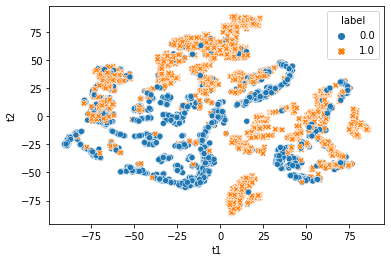

In [198]:
tsne_embedding_users = plot_tsne(data,U,train_interactions,"user_id")


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


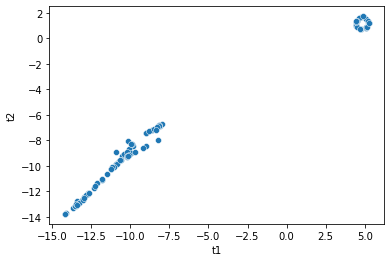

In [199]:
tsne_embedding_items = plot_tsne(data,I,test_interactions,"item_id")

# Testing

In [197]:
y, pred,auc = test_rodie(test, U, I, data_torch, model_, device)

Testing...


 99%|█████████▉| 159/160 [00:03<00:00, 52.02it/s]



 AUC Score = 0.6696094341617189
